In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
all_data = pd.read_csv('all_data.csv')

In [3]:
all_data['Bundesland'] = all_data.districtId // 1000
#Bundesland string didn't fit into the 25MB file limit 
#of Github for the rki_raw file

In [4]:
def plot_district(districtId):
    district_data = all_data[all_data.districtId == districtId].copy()
    district_name = district_data.district_name.iat[0]
    x= district_data.week_no
    y1 = district_data.AnzahlFall_cumul_per_cap
    y2 = district_data.target
    y3 = district_data.target_predicted

    fig, ax1 = plt.subplots()

    color1 = 'gray'
    ax1.set_xlabel('week')
    ax1.set_ylabel('Cumulated Cases', color = color1)
    ax1.plot(x,y1, color = color1,marker='o')
    ax1.tick_params(axis='y', color=color1)
    ax1.set_xlim(x.min(),x.max())
    ax1.set_title(district_name + '\nDashed line - prediction; solid line - observed')

    ax2 = ax1.twinx()
    color2 = 'k'
    ax2.set_ylabel('Weekly Log-R0', color = color2)
    ax2.plot(x, y2, color = color2)
    ax2.plot(x, y3, color = color2, linestyle='--')
    ax2.fill_between(x, y2, y3, where=y3 >= y2,alpha=.6, facecolor='green', interpolate=True)
    ax2.fill_between(x, y2, y3, where=y3 <= y2,alpha=.6, facecolor='red', interpolate=True)
    ax2.tick_params(axis='y', labelcolor = color2)
    #ax2.set_ylim((-1,1))
    ax2.grid(None)

    fig.tight_layout()
        
    plt.show()

In [5]:
ferien_dict = {8:31,
               9:31,
               11:27,
               12:27,
               4:25,
               2:27,
               6:28,
               13:26,
               3:30,
               5:27,
               7:28,
               10:28,
               14:30,
               15:30,
               1:27,
               16:30}

summer_vac_df = pd.DataFrame()
offset=0
#offsetting the summer vacation by one week, even though performance measure/target already
#'looks' one week into the future, to include all travel-returners' effects. Could also be 0 or 2?
#edit: instead of offesetting, I think it's better to simply include all of the vacation plus the first week afterwards,
# so range(0,7) below.

for bl,start in ferien_dict.items():
    ferien = [start+offset+no for no in range(0,7)]
    bl_data = all_data.loc[all_data.Bundesland==bl,['districtId','week_no']].copy()
    bl_data['summer_vac'] = bl_data.week_no.isin(ferien)
    summer_vac_df = summer_vac_df.append(bl_data)
    
all_data = pd.merge(all_data, summer_vac_df, how='outer')
    


In [6]:
def deviance_sum_interval(first_week, last_week):
    cut_data = all_data[all_data.week_no.between(first_week,last_week, inclusive=True)].copy()
    deviance_sums = cut_data.groupby('districtId')['deviance'].mean().reset_index()
    return deviance_sums

In [7]:
# wmin = all_data.week_no.min()
# wmax = all_data.week_no.max()
lockdown = deviance_sum_interval(12,21)
summer = all_data[all_data.summer_vac].groupby('districtId')['deviance'].mean().reset_index()
deviance_merge = pd.merge(lockdown, summer,
                      on='districtId',how='outer',
                      suffixes=('_lockdown','_summer'))

In [8]:
structural = all_data[['districtId','rur_z','ses_z']].drop_duplicates()
deviance_df = deviance_merge.merge(structural).set_index('districtId')

In [9]:
deviance_df

,deviance_lockdown,deviance_summer,rur_z,ses_z
districtId,,,,
1001,-0.080756,-0.210801,-1.294640,-0.754626
1002,0.171018,-0.246323,-1.693752,-0.083339
1003,0.129173,-0.106942,-1.072525,-0.424751
1004,0.039647,-0.282525,-0.758816,-0.735324
1051,0.047924,-0.038758,1.243732,-0.703769
...,...,...,...,...
16073,-0.032694,-0.110046,0.815757,-1.578834
16074,-0.012318,-0.168759,0.431247,-1.111397
16075,-0.224070,-0.213340,0.769875,-1.375601


In [10]:
deviance_z_df = pd.DataFrame()
scaler = StandardScaler()

for i in deviance_df.index:
    center_rur = deviance_df.rur_z.at[i]
    center_ses = deviance_df.ses_z.at[i]
    distances = np.sqrt((deviance_df.rur_z - center_rur)**2 + (deviance_df.ses_z - center_ses)**2)
    peers_df = deviance_df[distances <= 1].copy()
    n_peer_kernel = peers_df.shape[0]
    output_dict = {'districtId':i,
                  'n_peer_kernel':n_peer_kernel}
    for t in ['lockdown','summer']:
        var_name = t + '_z'
        peers_df[var_name] = scaler.fit_transform(peers_df['deviance_' + t].values.reshape(-1,1))
        output_dict[var_name] = peers_df[var_name].at[i]
        
        
    deviance_z_df = deviance_z_df.append(output_dict, ignore_index=True)
       

In [11]:
deviance_df = pd.merge(deviance_df.reset_index(),deviance_z_df)

In [12]:
for c in ['lockdown_z','summer_z']:
    print(c)
    for cut_off in [1.96, 2.33, 2.58]:
        above_df = deviance_df[deviance_df[c] >= cut_off]
        print('Above',cut_off,'cut-off:',above_df.shape[0],'\nincluding',
             sum(above_df.n_peer_kernel < 31),'with fewer than 30 peers and',
             sum(above_df.n_peer_kernel < 21),'with fewer than 20 peers.')

lockdown_z
Above 1.96 cut-off: 5 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.33 cut-off: 1 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.58 cut-off: 0 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
summer_z
Above 1.96 cut-off: 15 
including 2 with fewer than 30 peers and 2 with fewer than 20 peers.
Above 2.33 cut-off: 6 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.
Above 2.58 cut-off: 4 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.


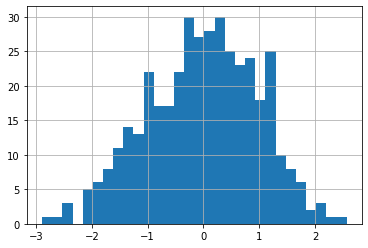

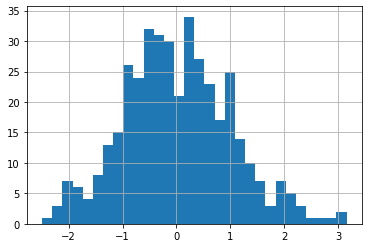

In [13]:
for c in ['lockdown_z','summer_z']:
    deviance_df[c].hist(bins=30)
    plt.show()

Best during lockdown


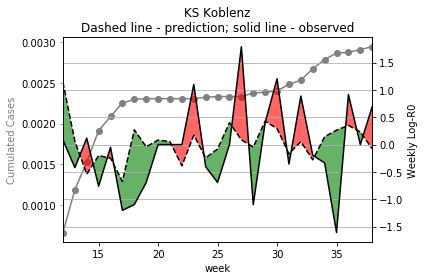

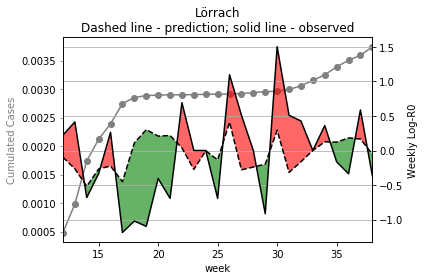

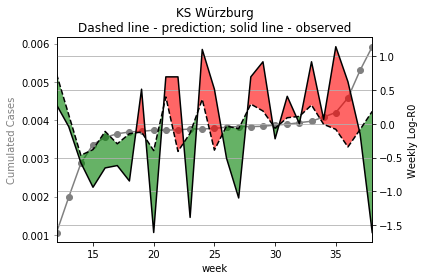

Worst during lockdown


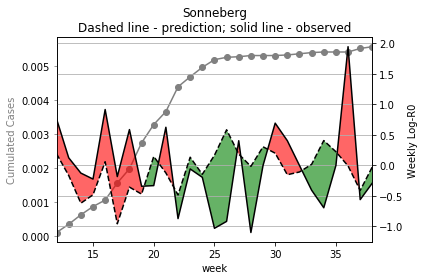

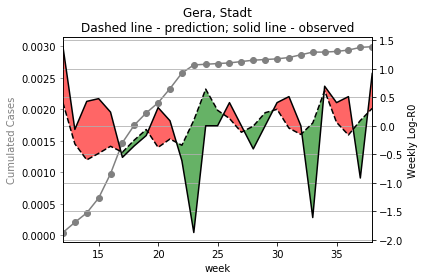

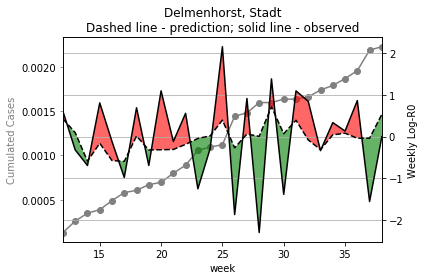

Best during summer


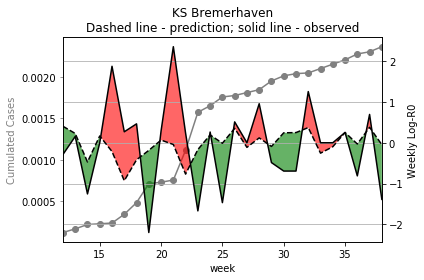

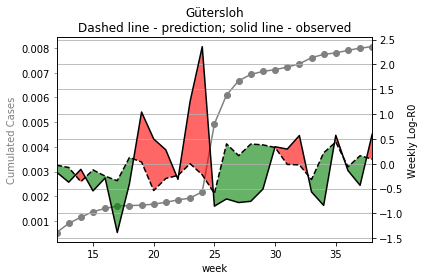

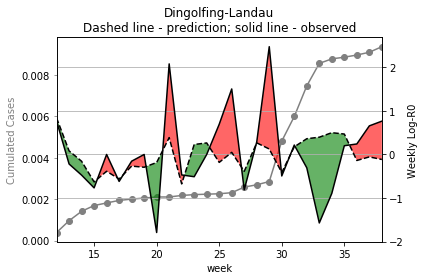

Worst during summer


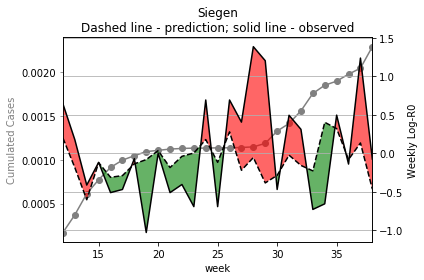

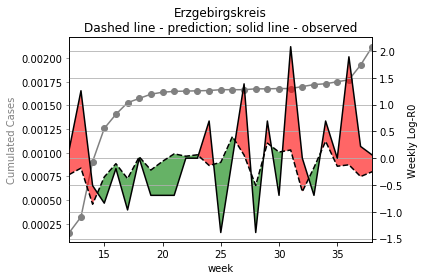

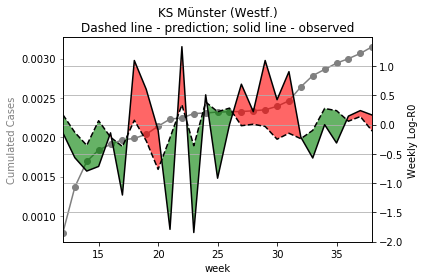

In [14]:
def top_flop_n(n, var, flop=False):
    sorted_df = deviance_df.sort_values(var,ascending=flop)
    for i in range(n):
        plot_district(sorted_df.districtId.iat[i])

N=3 

for var in ['lockdown_z','summer_z']:
    
    print('Best during',var[:-2])
    top_flop_n(N,var,flop=False)
    
    print('Worst during',var[:-2])
    top_flop_n(N,var,flop=True)

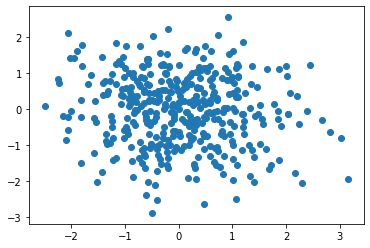

In [15]:
plt.scatter(deviance_df.summer_z,deviance_df.lockdown_z)

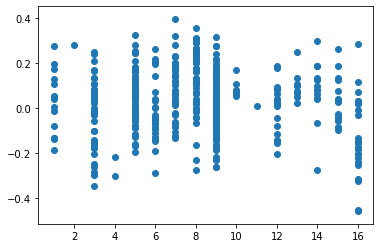

In [16]:
plt.scatter(deviance_df.districtId//1000,deviance_df.deviance_lockdown)

In [17]:
# distance_dict = {}
# for i in deviance_df.index:
#     center_rur = deviance_df.rur_z.loc[i]
#     center_ses = deviance_df.ses_z.loc[i]
#     distances = np.sqrt((deviance_df.rur_z - center_rur)**2 + (deviance_df.ses_z - center_ses)**2)
#     distance_dict[i] = distances
    

In [18]:
# n_dict = {}
# width = 2
# factor = np.sqrt(np.sqrt(.5))
# b = True
# while b:
#     n_per = {}
#     for k, v in distance_dict.items():
#         n_per[k] = np.sum(v <= width)
#     n_dict[width] = n_per
#     width *= factor
#     width = np.round(width,2)
    
#     if width < .1:
#         b = False

In [19]:
# for k, v in n_dict.items():
#     print('Kernel radius:',k)
#     vals = np.array([*v.values()])
#     print('Percentage below N=30:',np.round(100*np.mean(vals<30),1))
#     print('Percentage below N=20:',np.round(100*np.mean(vals<20),1))
#     plt.hist(vals,bins=30)
#     plt.axvline(30)
#     plt.show()

In [20]:
# for k, v in n_dict
#     np.mean(np.array([*n_dict[1.0].values()]) < 30)

In [21]:
# from sklearn.preprocessing import StandardScaler

In [22]:
# sclr = StandardScaler()

# for t in ['lockdown','summer']:
#     var = 'deviance_' + t 
#     deviance_df[var + '_zscore'] = sclr.fit_transform(np.array(deviance_df[var]).reshape(-1,1))

In [23]:
# for c in deviance_df.columns:
#     print(c)
#     deviance_df[c].hist(bins=30)
#     plt.show()
    

In [24]:
# for c in ['deviance_lockdown_zscore','deviance_summer_zscore']:
#     print(c)
#     for cut_off in [1.96, 2.33, 2.58]:
#         print('Above',cut_off,'cut-off:',sum(deviance_df[c] >= cut_off))

In [25]:
# sns.jointplot(deviance_df.iloc[:,1],deviance_df.iloc[:,2],kind='kde')
# print('Correlation:',np.corrcoef(deviance_df.iloc[:,1],deviance_df.iloc[:,2])[1,0])

In [26]:
# def get_top_x(variable, x=10):
#     return deviance_df.sort_values(variable,ascending=False).iloc[:x]

In [27]:
# get_top_x('deviance_lockdown')

In [28]:
# get_top_x('deviance_summer')